# Regolarizzazione {#sec-regularization}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [2]:
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from scipy import stats, integrate
import arviz as az
from scipy.stats import norm, t
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import cmdstanpy
from cmdstanpy import CmdStanModel

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

In [3]:
seed: int = sum(map(ord, "beta_binomial_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione {.unnumbered}


## Regolarizzazione e Selezione di Variabili

La regolarizzazione è un potente strumento per affrontare il problema della **selezione di variabili** nei modelli statistici, in particolare quando abbiamo a disposizione un numero limitato di dati rispetto alla complessità del modello che desideriamo stimare. Questo approccio è essenziale quando il numero di predittori supera quello delle osservazioni o quando è necessario evitare l'**overfitting**, ovvero l'adattamento eccessivo del modello ai dati disponibili. La regolarizzazione consente di migliorare l'accuratezza delle previsioni e di aumentare la generalizzazione del modello su nuovi dati.

Il **trade-off bias-varianza** è alla base della regolarizzazione. In sostanza, aggiungendo troppe variabili in un modello, il rischio è di ridurre la varianza del modello ma aumentare il bias, cioè la distorsione nelle previsioni. All'opposto, un modello troppo semplice riduce il bias ma aumenta la varianza. La regolarizzazione cerca di trovare il giusto equilibrio riducendo la complessità del modello senza perdere troppa informazione rilevante.

Tradizionalmente, i frequentisti affrontano questo problema con metodi di **selezione del modello** basati su teorie informative (come il criterio di Akaike, AIC), che permettono di scegliere il modello migliore tra diverse alternative. Tuttavia, anche i **bayesiani** possono utilizzare queste tecniche (vedi la sezione seguente sugli approcci IT bayesiani). Tuttavia, in molti casi, la **regolarizzazione basata su priors** è una soluzione più efficace e naturale per controllare la complessità del modello.

### Il Ruolo della Regolarizzazione

La regolarizzazione tramite **priori debolmente informativi** o **priors restrittivi** permette di imporre delle penalizzazioni sui coefficienti dei predittori, spingendoli verso zero se non sono supportati dai dati. Questo approccio è particolarmente utile in contesti in cui abbiamo molti predittori e pochi dati. In questi casi, impostare dei **priori restrittivi** aiuta a ridurre l'incertezza e a mantenere il modello più semplice e interpretabile.

L'idea è di utilizzare priori che siano intenzionalmente più restrittivi di quelli che useremmo se volessimo esprimere la nostra "pura" incertezza sui parametri. Questo permette di **controllare la complessità del modello**, rendendo possibile la selezione automatica delle variabili rilevanti durante il processo di inferenza.

In sintesi, la **regolarizzazione** è uno strumento importante per la selezione di variabili nei modelli statistici complessi. Non solo permette di gestire modelli con molti predittori rispetto al numero di dati disponibili, ma evita anche il rischio di sovra-adattamento, garantendo un compromesso ottimale tra bias e varianza.

## Esempio di Applicazione

Per illustrare come funziona la regolarizzazione nella selezione delle variabili, consideriamo un esempio con un dataset contenente 100 predittori. Tra questi, solo i primi 10 hanno un effetto reale sui dati, mentre i restanti 90 non hanno alcun effetto. In questo contesto, la regolarizzazione permette di identificare i predittori rilevanti (i primi 10) riducendo o eliminando l'influenza degli altri 90 predittori. Questo processo aiuta a ridurre il rumore nel modello, migliorandone la capacità di fare previsioni accurate. Seguiremo qui la [trattazione](http://florianhartig.github.io/LearningBayes/) proposta da Florian Hartig.

In [6]:
# Setting seed for reproducibility
np.random.seed(1)

# Generating random data
dat = pd.DataFrame(np.random.uniform(-0.5, 0.5, size=(200, 100)))
dat["y"] = np.random.normal(size=200)
dat["y"] = dat["y"] + dat.iloc[:, :10].sum(axis=1)

# Preparing data for regression
X = dat.iloc[:, :100].values
y = dat["y"].values

Eseguiamo l'analisi frequentista.

In [7]:
# Fitting full model (equivalent to lm in R)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Calcoliamo l'indice MSE e rappresentiamo visivamente la grandezza delle stime dei coefficienti di regressione delle 100 variabili inserite nel modello.

In [10]:
# True coefficients and estimated coefficients
true = np.concatenate([np.ones(10), np.zeros(90)])
estimated = model.coef_

# Mean Squared Error
MSE = np.round(np.var(true - estimated), 4)

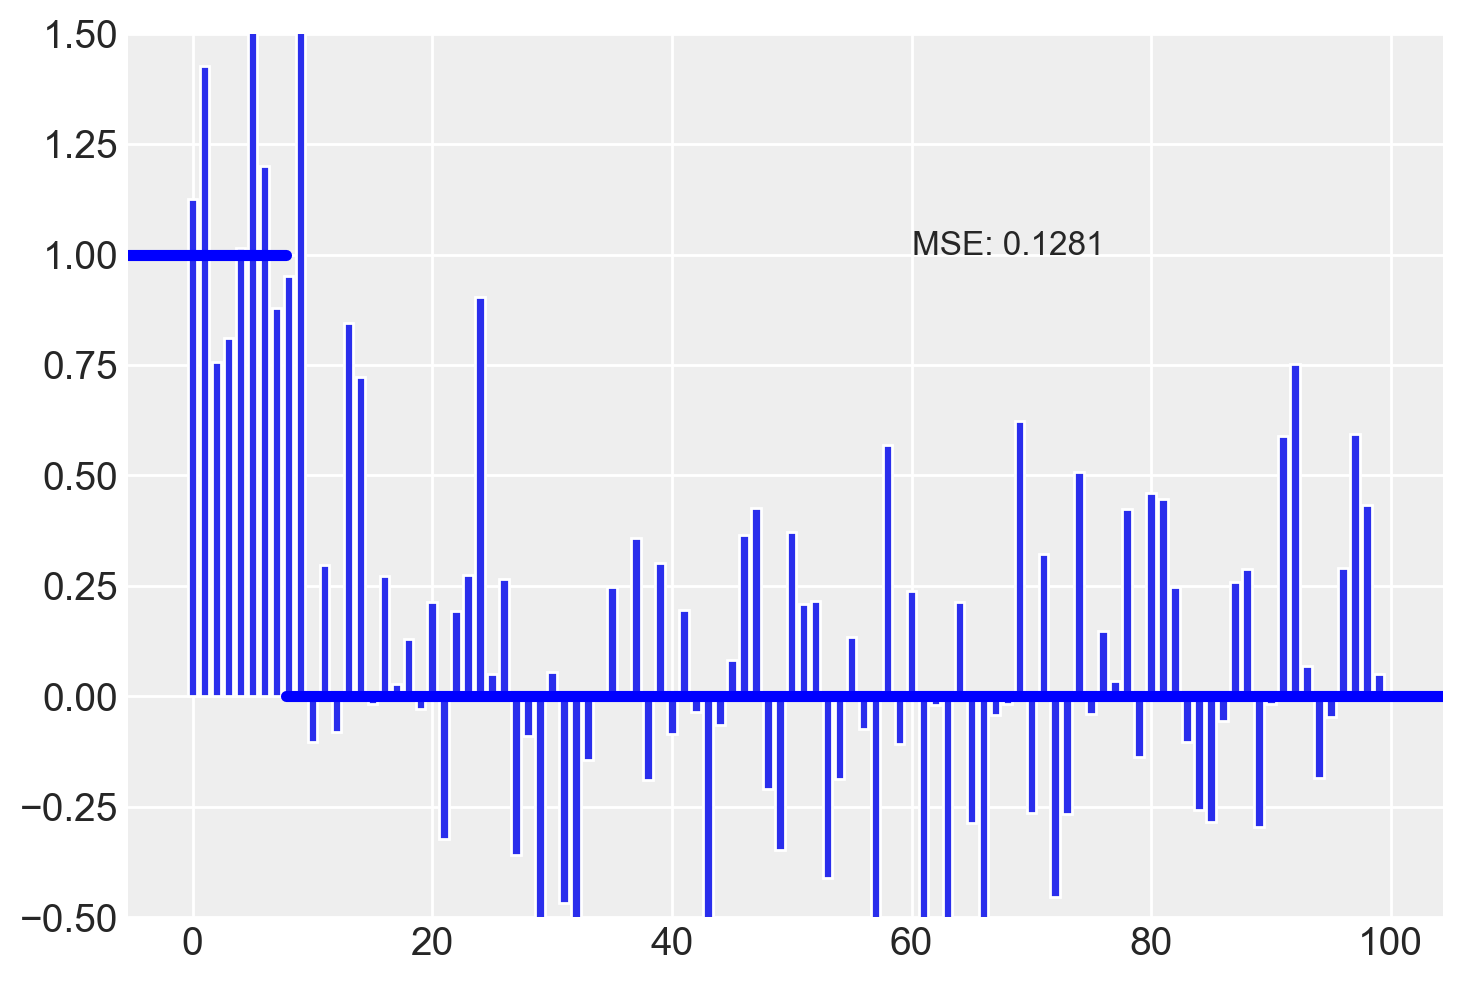

In [12]:
# Function to plot the estimates
def plot_estimates(estimates):
    MSE = np.round(np.var(true - estimates), 4)
    plt.bar(np.arange(len(estimates)), estimates)
    plt.axhline(y=1, xmin=0, xmax=12 / len(estimates), color="blue", linewidth=4)
    plt.axhline(y=0, xmin=12 / len(estimates), xmax=1, color="blue", linewidth=4)
    plt.ylim(-0.5, 1.5)
    # plt.xticks(rotation=90)
    plt.text(60, 1, f"MSE: {MSE}", fontsize=12)
    plt.show()


# Plotting the estimates
plot_estimates(estimated)

Notiamo che alcune variabili irrilevanti hanno coefficienti la cui grandezza è maggiore di quella delle variabili che hanno un vero effetto sulla $y$. 

## Prior non informativi 

Ovviamente, l'equivalente bayesiano del modello con ampi prior non informativi produce lo stesso risultato.

In [16]:
# Define the Stan model code
model_code_1 = """
data {
  int<lower=1> i_max;     // numero di osservazioni
  int<lower=1> p;         // numero di predittori (dimensione del vettore a)
  matrix[i_max, p] x;     // matrice delle covariate
  vector[i_max] y;        // variabile dipendente
}

parameters {
  vector[p] a;            // vettore dei coefficienti
  real b;                 // intercetta
  real<lower=0> sigma;    // deviazione standard (al posto di tau)
}

model {
  vector[i_max] mu;

  // Likelihood
  for (i in 1:i_max) {
    mu[i] = dot_product(a, x[i]) + b; // calcola la media mu per ogni osservazione
  }
  y ~ normal(mu, sigma); // distribuzione normale per y

  // Prior distributions
  a ~ normal(0, 100);   // priors per i coefficienti (equivalente a dnorm(0, 0.0001))
  b ~ normal(0, 100);   // prior per l'intercetta
  sigma ~ cauchy(0, 2); // prior per sigma (alternativa al dgamma per tau)
}
"""

# Create a temporary file for the Stan model
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as f:
    f.write(model_code_1)
    stan_file = f.name

In [17]:
model_1 = CmdStanModel(stan_file=stan_file)

In [96]:
# Generazione dei dati simulati come fatto in precedenza
np.random.seed(1)
dat = pd.DataFrame(np.random.uniform(-0.5, 0.5, size=(200, 100)))
dat["y"] = np.random.normal(size=200)
dat["y"] = dat["y"] + dat.iloc[:, :10].sum(axis=1)

# Preparazione dei dati per Stan
stan_data = {
    "y": dat["y"].values,  # Vettore delle risposte
    "x": dat.iloc[:, :100].values,  # Matrice delle covariate
    "i_max": len(dat),  # Numero di osservazioni (righe)
    "p": dat.shape[1] - 1,  # Numero di predittori (100 colonne)
}

# print(stan_data)  # Per vedere i dati

In [22]:
samples_1 = model_1.sample(
    data=stan_data,
    seed=123,
    chains=4,
    parallel_chains=4,  # No data needed for this model
    show_progress=False,
    show_console=False,
)

In [23]:
# Estrazione dei campioni posteriori dai parametri 'a', 'b', e 'sigma'
posterior_a = samples_1.stan_variable("a")  # Campioni posteriori per 'a'
posterior_b = samples_1.stan_variable("b")  # Campioni posteriori per 'b'
posterior_sigma = samples_1.stan_variable("sigma")  # Campioni posteriori per 'sigma'

# Calcolo della mediana per ciascuno dei parametri 'a'
est_a = np.median(posterior_a, axis=0)

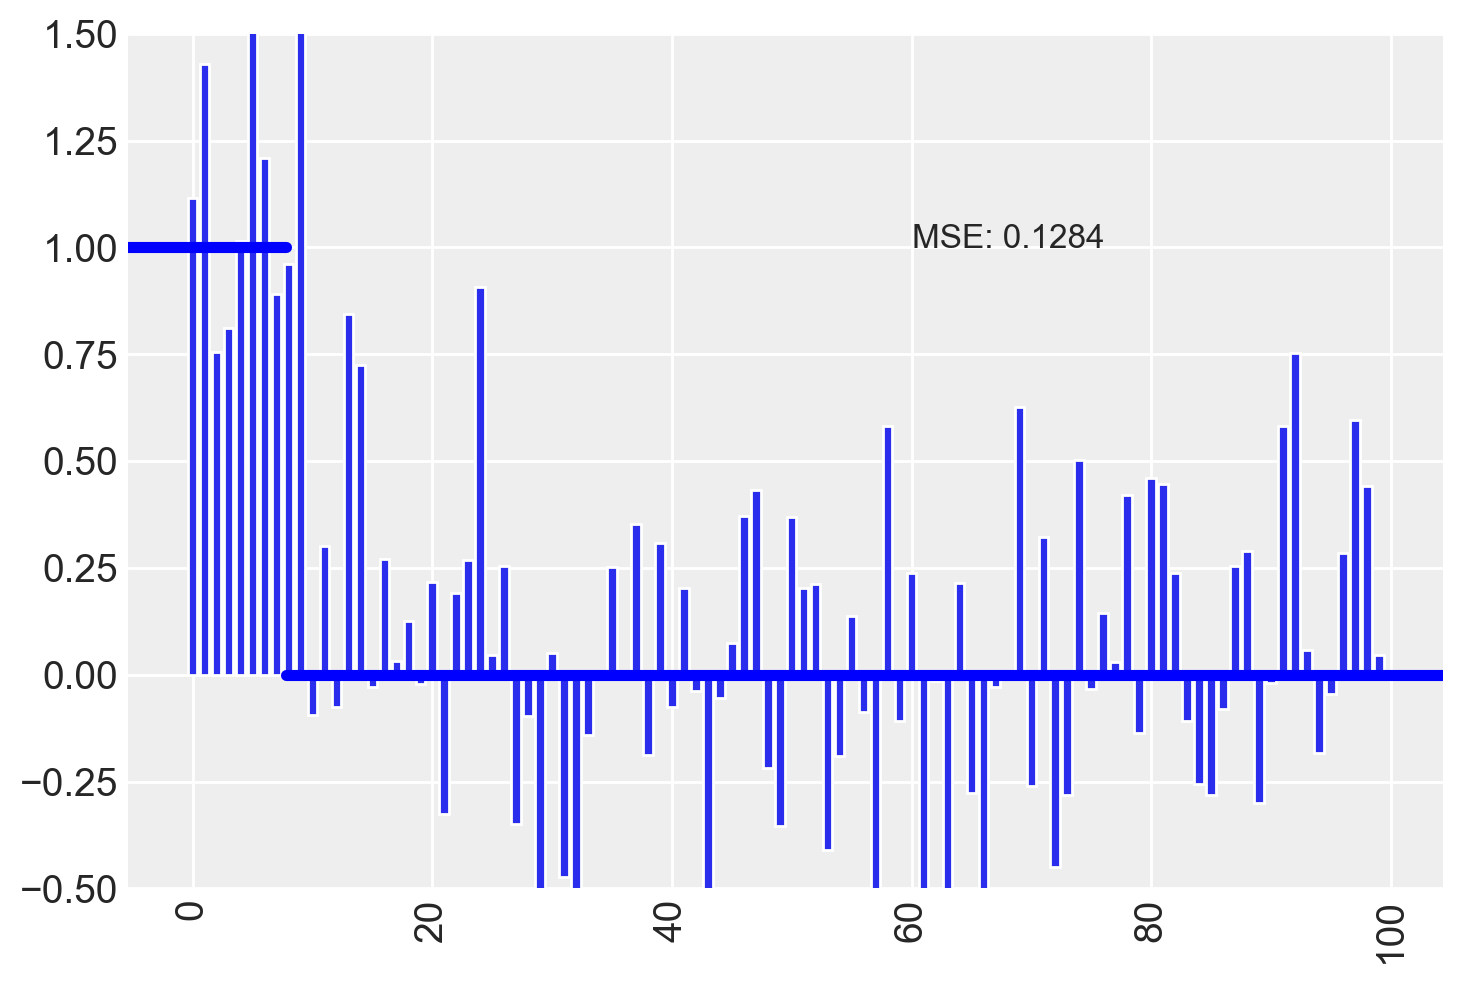

In [24]:
# Funzione per il grafico (simile a quella in R)
def plot_estimates(estimates):
    MSE = np.round(np.var(true - estimates), 4)
    plt.bar(np.arange(len(estimates)), estimates)
    plt.axhline(y=1, xmin=0, xmax=12 / len(estimates), color="blue", linewidth=4)
    plt.axhline(y=0, xmin=12 / len(estimates), xmax=1, color="blue", linewidth=4)
    plt.ylim(-0.5, 1.5)
    plt.xticks(rotation=90)
    plt.text(60, 1, f"MSE: {MSE}", fontsize=12)
    plt.show()


# Esegui il grafico delle stime di 'a'
true = np.concatenate([np.ones(10), np.zeros(90)])  # Valori veri per confronto
plot_estimates(est_a)

## Priori di Regolarizzazione Moderata

I <font color='orange'>priori di regolarizzazione moderata</font> sono una tecnica molto utile in modelli di regressione per gestire i problemi di identificabilità dei parametri e prevenire l'overfitting, senza influenzare eccessivamente le stime dei parametri. L'idea alla base è di dare una lieve spinta ai coefficienti di regressione verso zero, riducendo la complessità del modello senza compromettere la capacità di fare previsioni accurate.

Nel contesto dei modelli di regressione, i priori di regolarizzazione moderata (*mildly regularizing priors*) sono usati per imporre una penalizzazione sui coefficienti di regressione, che li spinge verso zero. Tuttavia, la forza di questa penalizzazione è mantenuta debole in modo da non distorcere significativamente le stime dei parametri, ma sufficiente a stabilizzare il modello.

Un coefficiente di regressione è il parametro che esprime la forza e la direzione della relazione tra una variabile predittiva (covariata) e la variabile dipendente (risposta). In assenza di regolarizzazione, i coefficienti possono assumere valori molto grandi se ci sono correlazioni tra predittori o se il modello è complesso rispetto alla quantità di dati disponibili. I priori di regolarizzazione moderata impediscono che questo accada.

### Implementazione dei Priori Moderati

Nel seguente codice Stan, i **priori di regolarizzazione moderata** vengono applicati ai coefficienti di regressione $a$, che rappresentano i predittori del modello. Il prior su ogni $a[i]$ è una distribuzione normale centrata su zero con una varianza moderata:

```stan
a ~ normal(0, sqrt(0.5));  // prior moderato sui coefficienti a[i]
```

Ciò significa che i coefficienti $a[i]$ hanno una distribuzione normale con media zero e una deviazione standard di circa 0.7, che corrisponde a una penalizzazione moderata (non troppo forte) verso lo zero. Questa scelta regolarizza il modello senza influenzare eccessivamente i coefficienti stimati.

Inoltre, la prior per l'intercetta $b$ è definita come:

```stan
b ~ normal(0, sqrt(0.0001));  // prior debole per l'intercetta
```

Questo significa che l'intercetta viene trattata con una prior molto più restrittiva, in quanto ci si aspetta che l'intercetta debba essere piccola (vicina a zero) a priori. Ciò permette di regolarizzare il modello senza distorcere l'influenza dei predittori.

### Quando Usare i Priori Moderati?

I **priori moderati** sono particolarmente utili quando:

1. **Dati ridotti o rumorosi**: In presenza di pochi dati, o di dati rumorosi, i coefficienti di regressione possono diventare non identificabili o altamente instabili. La regolarizzazione moderata aiuta a evitare che i parametri crescano troppo, stabilizzando le stime.
   
2. **Modelli con molti predittori**: Quando il numero di predittori è elevato, c'è il rischio che il modello si adatti troppo ai dati, generando un problema di overfitting. I priori moderati riducono l'effetto di predittori meno importanti spingendoli verso zero.

3. **Evita la selezione dei modelli**: L'uso di priori moderati può spesso rendere superfluo il processo di selezione del modello (che è costoso in termini computazionali), poiché i predittori meno rilevanti vengono naturalmente ridotti verso zero.

### Effetti Pratici

Il vantaggio principale dei priori di regolarizzazione moderata è che mantengono il modello stabile e ben identificato, specialmente nei casi di modelli con molti predittori, evitando che i coefficienti diventino troppo grandi. Allo stesso tempo, non distorcono significativamente le stime dei parametri, il che significa che i predittori con effetti reali significativi non vengono penalizzati eccessivamente.

Nel contesto di modelli di regressione con predittori scalati e centrati, ci si aspetta che gli effetti forti abbiano dimensioni dell'effetto vicine a 1. Pertanto, un prior che impone una varianza compresa tra 1 e 10 (come nel caso della prior normale con deviazione standard di circa 0.7) è considerato moderato, e aiuta a mantenere il modello sotto controllo.

### Considerazioni Finali

In definitiva, i **priori di regolarizzazione moderata** rappresentano un compromesso efficace tra la modellizzazione flessibile e la prevenzione del sovra-adattamento. Questa tecnica di regolarizzazione spinge dolcemente i coefficienti verso zero, mantenendo il modello semplice e robusto, senza imporre restrizioni troppo forti che potrebbero distorcere i risultati.

### Esempio di Implementazione del Modello

Nel codice Stan, l'implementazione dei priori moderati è strutturata come segue:

In [25]:
# Define the Stan model code
model_code_2 = """
data {
  int<lower=1> i_max;     // numero di osservazioni
  int<lower=1> p;         // numero di predittori (dimensione del vettore a)
  matrix[i_max, p] x;     // matrice delle covariate
  vector[i_max] y;        // variabile dipendente
}

parameters {
  vector[p] a;            // vettore dei coefficienti
  real b;                 // intercetta
  real<lower=0> sigma;    // deviazione standard
}

model {
  vector[i_max] mu;

  // Likelihood
  for (i in 1:i_max) {
    mu[i] = dot_product(a, x[i]) + b; // calcola la media mu per ogni osservazione
  }
  y ~ normal(mu, sigma);  // distribuzione normale per y

  // Prior distributions
  a ~ normal(0, sqrt(0.5));  // prior debole per i coefficienti (equivalente a dnorm(0, 0.5))
  b ~ normal(0, sqrt(0.0001));  // prior debole per l'intercetta (equivalente a dnorm(0, 0.0001))
  sigma ~ cauchy(0, 2);      // prior debole per sigma (equivalente alla prior gamma su tau)
}
"""

# Create a temporary file for the Stan model
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as f:
    f.write(model_code_2)
    stan_file = f.name

In questo esempio, la prior sui coefficienti è una prior **moderatamente regolarizzante**, che aiuta a stabilizzare il modello senza imporsi eccessivamente sulle stime dei parametri.

In [26]:
model_2 = CmdStanModel(stan_file=stan_file)

samples_2 = model_2.sample(
    data=stan_data,
    seed=123,
    chains=4,
    parallel_chains=4,  # No data needed for this model
    show_progress=False,
    show_console=False,
)

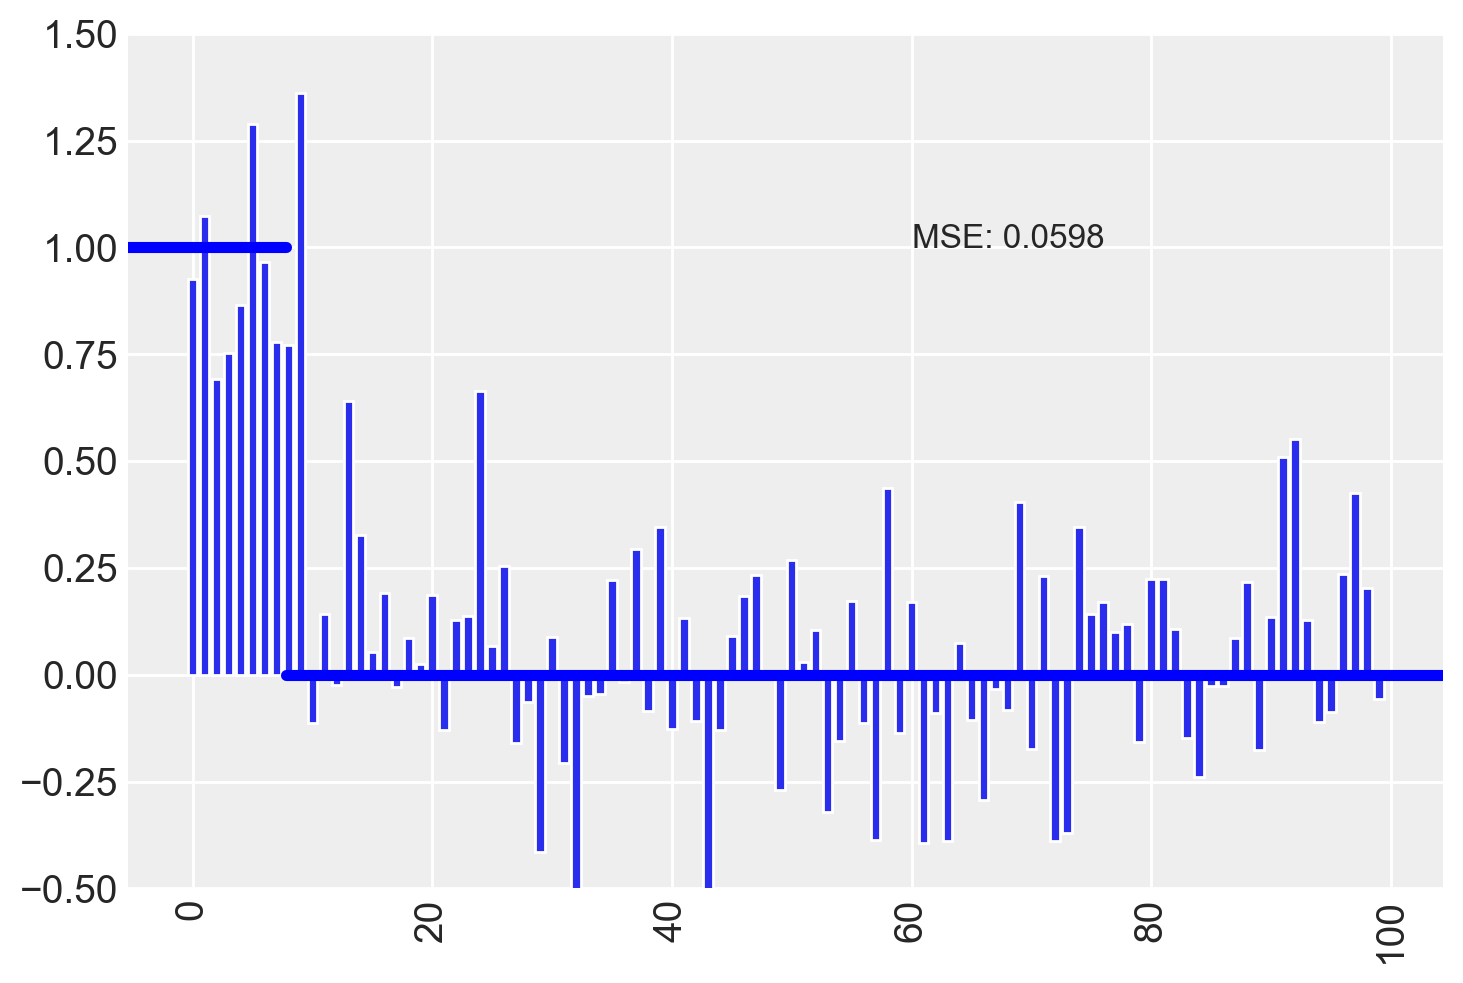

In [27]:
# Estrazione dei campioni posteriori dai parametri 'a', 'b', e 'sigma'
posterior_a = samples_2.stan_variable("a")  # Campioni posteriori per 'a'
posterior_b = samples_2.stan_variable("b")  # Campioni posteriori per 'b'
posterior_sigma = samples_2.stan_variable("sigma")  # Campioni posteriori per 'sigma'

# Calcolo della mediana per ciascuno dei parametri 'a'
est_a = np.median(posterior_a, axis=0)

# Esegui il grafico delle stime di 'a'
true = np.concatenate([np.ones(10), np.zeros(90)])  # Valori veri per confronto
plot_estimates(est_a)

Il MSE è diminuito, ma la stima degli effetti delle variabili irrilevanti, in molti casi, è simile a quella delle variabili veramente importanti. 

## Shrinkage Fisso e Adattivo

L'approccio di <font color='orange'>shrinkage</font> in un contesto bayesiano è una tecnica molto utilizzata per la regolarizzazione dei parametri in modelli di regressione complessi, specialmente quando ci sono molti predittori. La regolarizzazione riduce la varianza dei coefficienti di regressione, prevenendo fenomeni come l'overfitting, ovvero l'adattamento eccessivo del modello ai dati osservati.

### Shrinkage: Fisso vs Adattivo

Lo shrinkage può essere impostato in due modi:

1. **Shrinkage Fisso**:
   - È comune negli approcci frequentisti come il **Lasso** (L1) o il **Ridge** (L2).
   - In questo caso, si impone una penalizzazione (shrinkage) fissa ai coefficienti, determinata tramite tecniche come la **validazione incrociata** (cross-validation). Il parametro di shrinkage viene scelto per minimizzare l'errore di previsione.
   
2. **Shrinkage Adattivo**:
   - Nell'approccio bayesiano, lo shrinkage può essere trattato come un **parametro da stimare** direttamente all'interno del modello.
   - Questo approccio implica che non si impone un valore fisso per lo shrinkage, ma si utilizza una distribuzione a priori (detta **hyperprior**) per stimarlo in base ai dati osservati.
   - **Vantaggio**: Questo approccio adattivo è flessibile e permette al modello di "adattare" automaticamente il livello di shrinkage, rendendo l'analisi più robusta.

### Struttura del Modello

Nel codice Stan fornito, viene utilizzato uno **shrinkage adattivo**. Vediamo come funziona:

1. **Coefficiente Shrinkage**:
   - Per ogni predittore $a[i]$, si applica una distribuzione normale con media zero e deviazione standard data da $sdShrinkage$, che dipende dal parametro di shrinkage adattivo:

     $$
     a[i] \sim \mathcal{N}(0, sdShrinkage)
     $$

   - Questo introduce una forma di regolarizzazione che riduce i coefficienti $a[i]$ verso zero, soprattutto per i predittori meno significativi. Ciò aiuta a evitare che il modello sovra-adatti i dati.

2. **Parametro di Shrinkage Adattivo**:
   - Il parametro di precisione per lo shrinkage, $\tau_{\text{shrinkage}}$, viene modellato come una variabile aleatoria con una distribuzione gamma:

     $$
     \tau_{\text{shrinkage}} \sim \Gamma(0.001, 0.001)
     $$

   - Da questo parametro di precisione, si calcola $sdShrinkage$, che controlla l'intensità del shrinkage applicato ai coefficienti $a[i]$.

3. **Parallelismo con i Modelli a Effetti Casuali**:
   - Questo approccio è simile ai **modelli misti** (mixed models), in cui i coefficienti dei predittori vengono trattati come effetti casuali che seguono una distribuzione normale comune. In questo contesto, i coefficienti $a[i]$ possono essere visti come effetti casuali, la cui varianza è regolata dallo shrinkage.

4. **Prior per il Parametro di Shrinkage**:
   - Nel modello, lo shrinkage viene trattato come un parametro ignoto, e quindi viene posto un **hyperprior** su $\tau_{\text{shrinkage}}$ tramite una distribuzione gamma. Questo consente al modello di apprendere automaticamente il giusto livello di regolarizzazione dai dati, migliorando l'adattamento del modello.

### Implementazione del Modello in Stan

Nel codice Stan, la struttura del modello per lo shrinkage è implementata come segue:

In [28]:
# Define the Stan model code
model_code_3 = """
data {
  int<lower=1> i_max;     // numero di osservazioni
  int<lower=1> p;         // numero di predittori (dimensione del vettore a)
  matrix[i_max, p] x;     // matrice delle covariate
  vector[i_max] y;        // variabile dipendente
}

parameters {
  vector[p] a;            // vettore dei coefficienti
  real b;                 // intercetta
  real<lower=0> tau;      // parametro di precisione per y (equivalente a sigma^(-2))
  real<lower=0> tauShrinkage;  // parametro di precisione per il "shrinkage"
}

transformed parameters {
  real<lower=0> sigma;        // deviazione standard per y
  real<lower=0> sdShrinkage;  // deviazione standard per il "shrinkage"

  sigma = 1 / sqrt(tau);                // calcola sigma dalla precisione tau
  sdShrinkage = 1 / sqrt(tauShrinkage); // calcola sdShrinkage dalla precisione tauShrinkage
}

model {
  vector[i_max] mu;

  // Likelihood
  for (i in 1:i_max) {
    mu[i] = dot_product(a, x[i]) + b; // calcola la media mu per ogni osservazione
  }
  y ~ normal(mu, sigma);  // distribuzione normale per y

  // Prior distributions
  a ~ normal(0, sdShrinkage);  // prior per i coefficienti a[i], con shrinkage
  b ~ normal(0, sqrt(0.001));  // prior per l'intercetta b

  // Prior distributions per i parametri di precisione
  tauShrinkage ~ gamma(0.001, 0.001);  // prior per tauShrinkage
  tau ~ gamma(0.001, 0.001);           // prior per tau
}
"""

# Create a temporary file for the Stan model
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as f:
    f.write(model_code_3)
    stan_file = f.name

Qui:

- $\tau_{\text{shrinkage}}$ è il parametro che controlla lo shrinkage. Un valore più elevato di $\tau_{\text{shrinkage}}$ impone un maggiore shrinkage ai coefficienti $a[i]$, riducendo i valori di $a[i]$.
- $sdShrinkage$ rappresenta la deviazione standard per i coefficienti regolarizzati, e viene derivato direttamente da $\tau_{\text{shrinkage}}$.

In conclusione, l'uso dei *shrinkage priors* (fissi o adattivi) è fondamentale per ottenere stime più stabili e robusti in modelli con molti predittori. Il vantaggio dell'approccio *adattivo* è che il livello di shrinkage è stimato dal modello stesso, basato sui dati, anziché essere fissato a priori. Questo approccio, molto simile a quanto avviene nel *Lasso* e nel *Ridge Regression*, garantisce che i coefficienti dei predittori irrilevanti vengano ridotti verso zero, migliorando la selezione delle variabili e prevenendo l'overfitting.

In [29]:
model_3 = CmdStanModel(stan_file=stan_file)

samples_3 = model_3.sample(
    data=stan_data,
    seed=123,
    chains=4,
    parallel_chains=4,  # No data needed for this model
    show_progress=False,
    show_console=False,
)

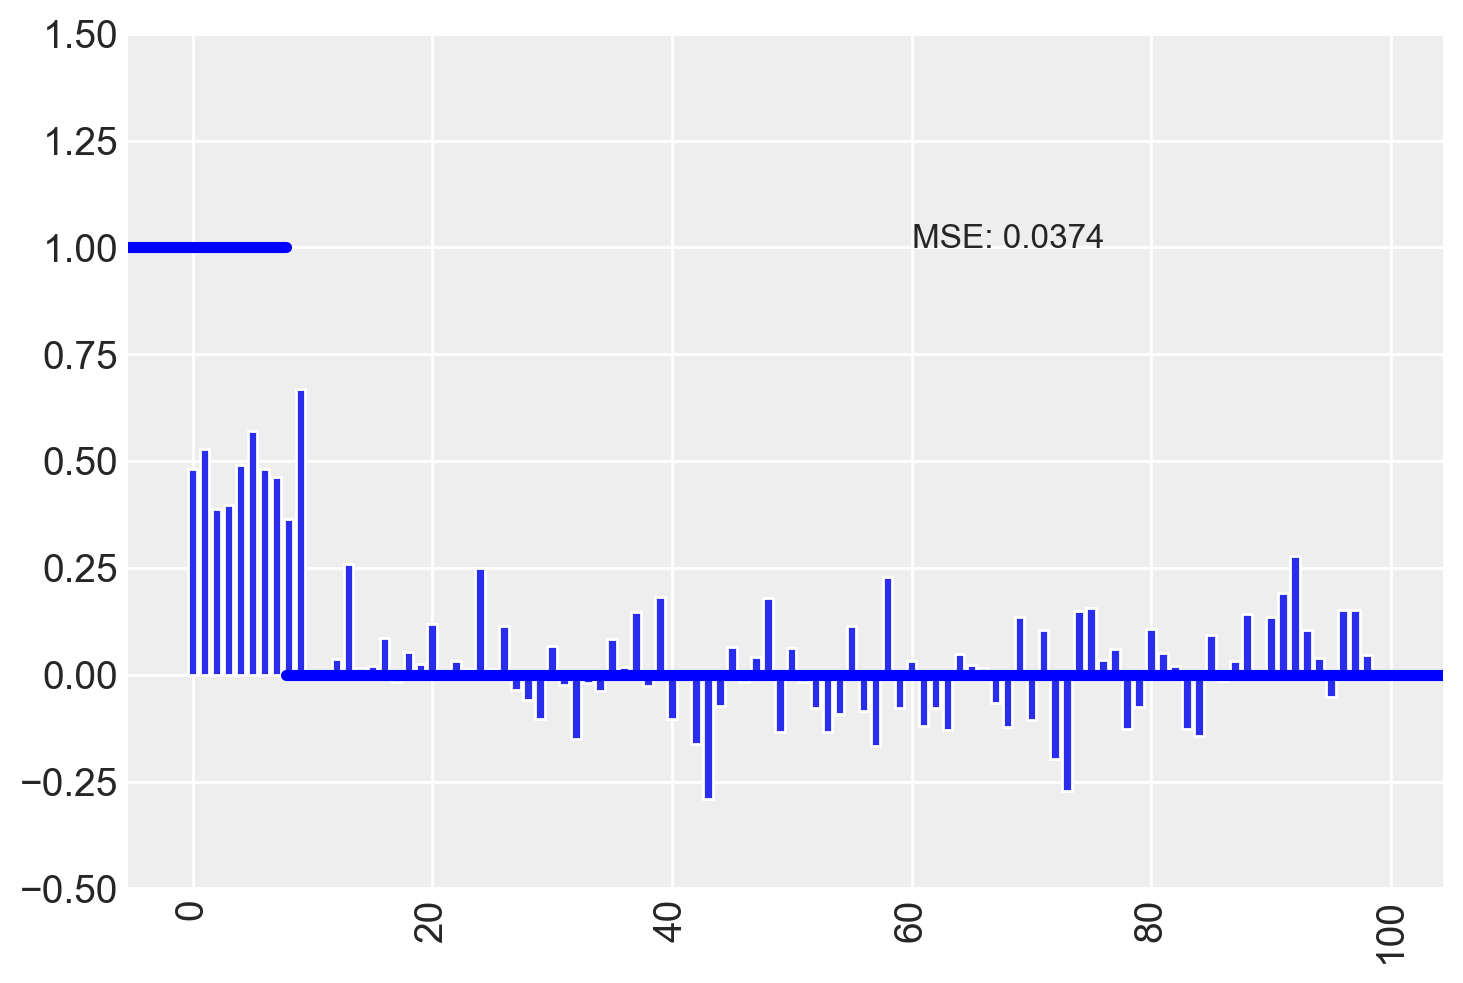

In [30]:
# Estrazione dei campioni posteriori dai parametri 'a', 'b', e 'sigma'
posterior_a = samples_3.stan_variable("a")  # Campioni posteriori per 'a'
posterior_b = samples_3.stan_variable("b")  # Campioni posteriori per 'b'
posterior_sigma = samples_3.stan_variable("sigma")  # Campioni posteriori per 'sigma'

# Calcolo della mediana per ciascuno dei parametri 'a'
est_a = np.median(posterior_a, axis=0)

# Esegui il grafico delle stime di 'a'
true = np.concatenate([np.ones(10), np.zeros(90)])  # Valori veri per confronto
plot_estimates(est_a)

Si noti che vi è una generale tendenza a ridurre le stime dei coefficienti associati a tutte le variabili. Questo consenti di separare meglio le variabili importanti da quelle irrilevanti. MSE è diminuito ancora.

## Selezione delle Variabili con Priori Spike and Slab

L’approccio **Spike and Slab**, noto anche come **SSVS (Stochastic Search Variable Selection)**, è una strategia utilizzata in contesti bayesiani per affrontare il problema della selezione delle variabili nei modelli di regressione. Questo metodo è stato sviluppato per individuare, tra un insieme di predittori, quelli che contribuiscono significativamente alla spiegazione della variabile dipendente. 

Nella regressione multipla, ci sono spesso molti predittori disponibili, e non tutti potrebbero essere rilevanti. Il problema della selezione delle variabili consiste nel determinare quali predittori includere nel modello finale, e l'approccio Spike and Slab offre una soluzione che combina regolarizzazione e selezione di variabili.

### Concetto di Spike and Slab

L'idea alla base dell'approccio Spike and Slab è semplice: ogni coefficiente di regressione viene trattato come se potesse essere "acceso" o "spento". Ciò significa che si assume che alcuni coefficienti siano praticamente pari a zero (spike), mentre altri siano liberi di variare (slab). Questa assunzione viene modellata utilizzando una combinazione di due componenti:
- **Spike**: Una distribuzione che concentra la probabilità attorno a valori molto piccoli (tipicamente intorno a zero), suggerendo che il predittore associato non è rilevante.
- **Slab**: Una distribuzione con maggiore varianza, che consente al coefficiente di variare significativamente, indicando che il predittore associato potrebbe essere rilevante.

In termini più concreti, l’approccio Spike and Slab combina una distribuzione concentrata attorno a zero (lo "spike") per le variabili irrilevanti, con una distribuzione meno restrittiva (lo "slab") per le variabili rilevanti. Questo modello riflette l’incertezza su quali predittori includere.

### Struttura del Modello Spike and Slab Utilizzato

Il modello presentato utilizza l'approccio Spike and Slab per regolarizzare i coefficienti dei predittori ($a_j$) e selezionare automaticamente le variabili rilevanti.

Il modello prevede:
1. **Coefficiente non ridotto** ($a_{\text{raw}}$): Ogni predittore ha un coefficiente grezzo che può essere regolarizzato.
2. **Probabilità di inclusione** ($p_{\text{ind}}$): Rappresenta la probabilità che un dato predittore sia incluso nel modello. Questa variabile è trattata come un parametro incerto e viene modellata con una distribuzione beta, che permette di variare tra $0$ e $1$.
3. **Shrinkage** ($\tau_{\text{shrinkage}}$): Uno shrinkage più forte riduce i coefficienti di regressione, contribuendo alla regolarizzazione. Lo shrinkage riduce l’effetto dei coefficienti, specialmente quelli meno significativi, avvicinandoli a zero.
4. **Variabile indicatrice continua** ($\theta_{\text{raw}}$): Non si usa una variabile indicatrice binaria (0 o 1) per determinare se un predittore è incluso o meno. Piuttosto, si utilizza una variabile continua tra 0 e 1, che viene moltiplicata per il coefficiente grezzo per modulare l’inclusione del predittore. Questo consente una transizione più morbida tra "incluso" ed "escluso", permettendo una maggiore flessibilità.

In sintesi, il modello funziona nel modo seguente:
- **Coefficiente finale ($a_j$)**: Viene ottenuto moltiplicando il coefficiente grezzo per la variabile indicatrice continua:

  $$
  a_j = \theta_{\text{raw},j} \times a_{\text{raw},j}
  $$

  Se $\theta_{\text{raw},j}$ è vicino a 0, il predittore $x_j$ sarà considerato irrilevante; se $\theta_{\text{raw},j}$ è vicino a 1, $x_j$ verrà considerato rilevante.

### Regolarizzazione con Spike and Slab

La regolarizzazione attraverso lo Spike and Slab funziona introducendo un compromesso tra semplicità del modello e adattamento ai dati. Questo approccio bilancia:

- **Inclusione di troppi predittori** (rischio di overfitting).
- **Inclusione di troppo pochi predittori** (rischio di underfitting).

Grazie alla distribuzione Spike and Slab, è possibile assegnare ai coefficienti una probabilità di inclusione, che permette di "accendere" o "spegnere" i predittori in base alla loro importanza. Nel modello presentato, la prior beta assegnata alla probabilità di inclusione ($p_{\text{ind}}$) consente di esprimere una preferenza iniziale sulla probabilità che un predittore sia incluso nel modello. 

### Esempio Psicologico: Selezione di Variabili nei Fattori di Rischio per la Depressione

Immaginiamo uno studio in cui vogliamo identificare i fattori di rischio per la depressione in un campione di popolazione. Abbiamo una lunga lista di potenziali fattori (età, livello di istruzione, esperienze passate, contesto familiare, variabili psicologiche come autostima, ecc.), ma non sappiamo in anticipo quali siano davvero rilevanti. 

Usando un modello Spike and Slab:

- Ogni fattore di rischio potenziale ha un coefficiente associato ($a_j$) che può essere "spento" (spike, coefficiente prossimo a 0) o "acceso" (slab, coefficiente rilevante).
- La variabile indicatrice continua ($\theta_{\text{raw}}$) riflette la probabilità che quel fattore sia un predittore significativo della depressione.
- Se la variabile indicatrice è vicina a 0, il fattore è irrilevante; se è vicina a 1, il fattore è considerato rilevante.

Questo approccio permette di identificare automaticamente i fattori di rischio più importanti, regolarizzando al contempo il modello per evitare che variabili irrilevanti creino rumore nei dati.

### Conclusione

L’approccio Spike and Slab è particolarmente potente per la selezione automatica delle variabili e la regolarizzazione. Permette di bilanciare il modello, evitando di includere troppe variabili irrilevanti (che porterebbero a overfitting) o di escludere variabili rilevanti (che porterebbero a underfitting). Nel contesto bayesiano, questo approccio combina l'uso di distribuzioni informative e non informative per selezionare i predittori migliori, risultando utile in molteplici aree, dalla psicologia alla statistica applicata.

In [90]:
# Define the Stan model code
model_code_4 = """
data {
  int<lower=1> i_max;     // numero di osservazioni
  int<lower=1> p;         // numero di predittori (dimensione del vettore a)
  matrix[i_max, p] x;     // matrice delle covariate
  vector[i_max] y;        // variabile dipendente
}

parameters {
  vector[p] a_raw;             // Coefficienti non ridotti
  real b;                      // Intercetta
  real<lower=0> tau;           // Precisione per la likelihood
  real<lower=0> tauShrinkage;  // Precisione per lo shrinkage
  real<lower=0, upper=1> pind; // Probabilità di inclusione
  vector<lower=0, upper=1>[p] theta_raw;  // Variabile continua tra 0 e 1 per l'inclusione
}

transformed parameters {
  vector[p] a;                 // Coefficienti finali dopo lo shrinkage
  real sigma;                  // Deviazione standard
  real sdShrinkage;            // Deviazione standard per lo shrinkage

  // Calcola sigma e sdShrinkage dalle precisioni
  sigma = 1 / sqrt(tau);
  sdShrinkage = 1 / sqrt(tauShrinkage);

  // Applica lo shrinkage ai coefficienti basato su theta_raw
  for (j in 1:p) {
    a[j] = theta_raw[j] * a_raw[j];  // Moltiplica per la variabile indicatrice continua
  }
}

model {
  vector[i_max] mu;

  // Likelihood
  for (i in 1:i_max) {
    mu[i] = dot_product(a, x[i]) + b;  // Calcola la media mu per ogni osservazione
  }
  y ~ normal(mu, sigma);  // Distribuzione normale per y

  // Prior distributions
  a_raw ~ normal(0, sdShrinkage);           // Prior per i coefficienti grezzi (slab)
  b ~ normal(0, 0.001);                    // Prior per l'intercetta
  theta_raw ~ beta(pind, 1 - pind);         // Prior per l'inclusione dei predittori (continua)
  pind ~ beta(0.2, 0.8);                   // Prior più estrema per una polarizzazione più forte
  tauShrinkage ~ gamma(0.01, 0.01);        // Prior per lo shrinkage, ancora più aggressivo
  tau ~ gamma(0.001, 0.001);               // Prior per tau
}
"""

# Create a temporary file for the Stan model
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as f:
    f.write(model_code_4)
    stan_file = f.name

In [91]:
model_4 = CmdStanModel(stan_file=stan_file)

samples_4 = model_4.sample(
    data=stan_data,
    seed=123,
    chains=4,
    parallel_chains=4,  
    show_progress=False,
    show_console=False,
)

Calcoliamo la probabilità di inclusione: per ogni campione, contiamo quanti `a[j]` sono significativamente lontani da 0.  Un modo semplice è considerare un cutoff, diciamo `|a[j]| > 0.1` come criterio di inclusione.

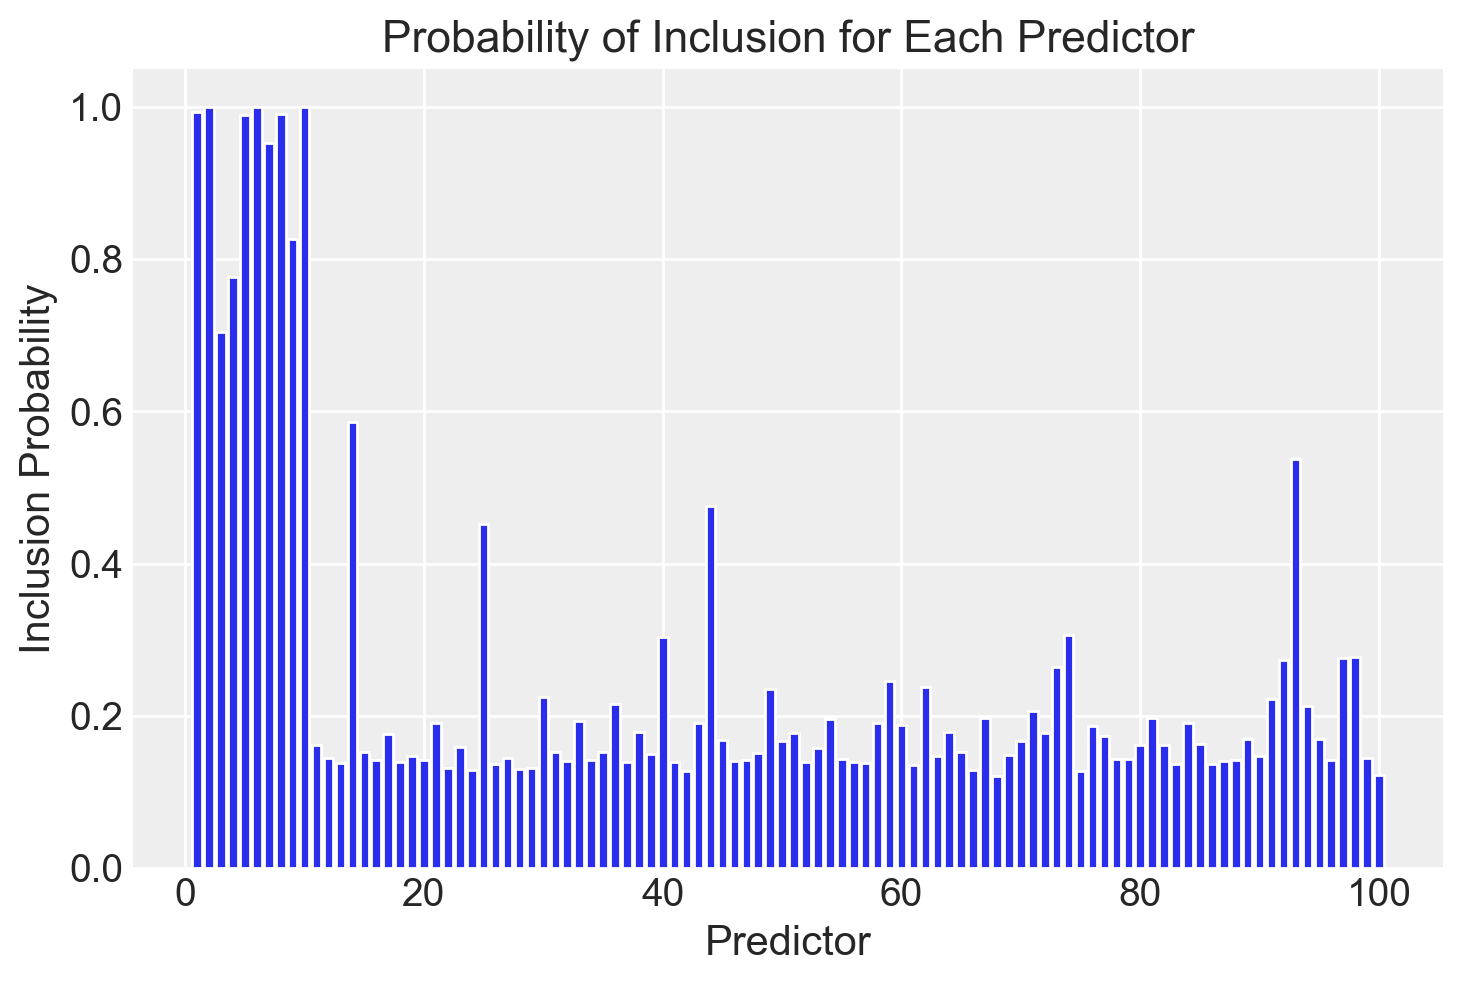

In [92]:
# Estrai i campioni di 'a' dai risultati di cmdstanpy
samples = samples_4.stan_variable("a")

incl_prob = np.mean(np.abs(samples) > 0.1, axis=0)

# Crea un barplot per visualizzare la probabilità di inclusione
plt.bar(range(1, len(incl_prob) + 1), incl_prob)
plt.xlabel("Predictor")
plt.ylabel("Inclusion Probability")
plt.title("Probability of Inclusion for Each Predictor")
plt.show()

Si noti che c'è una buona separazione tra le variabili importanti e quelle irrilevanti.

Calcoliamo ora le stime per ciascun predittore.

In [93]:
# Extract the 'a_raw' (the untransformed coefficients) and 'theta_raw' (inclusion indicators)
a_raw_samples = samples_4.stan_variable("a_raw")
theta_samples = samples_4.stan_variable("theta_raw")

# Compute the conditional estimates: a_raw * theta for each sample
conditional_samples = a_raw_samples * theta_samples

# Calculate the median of the conditional estimates for each predictor
condEst = np.median(conditional_samples, axis=0)

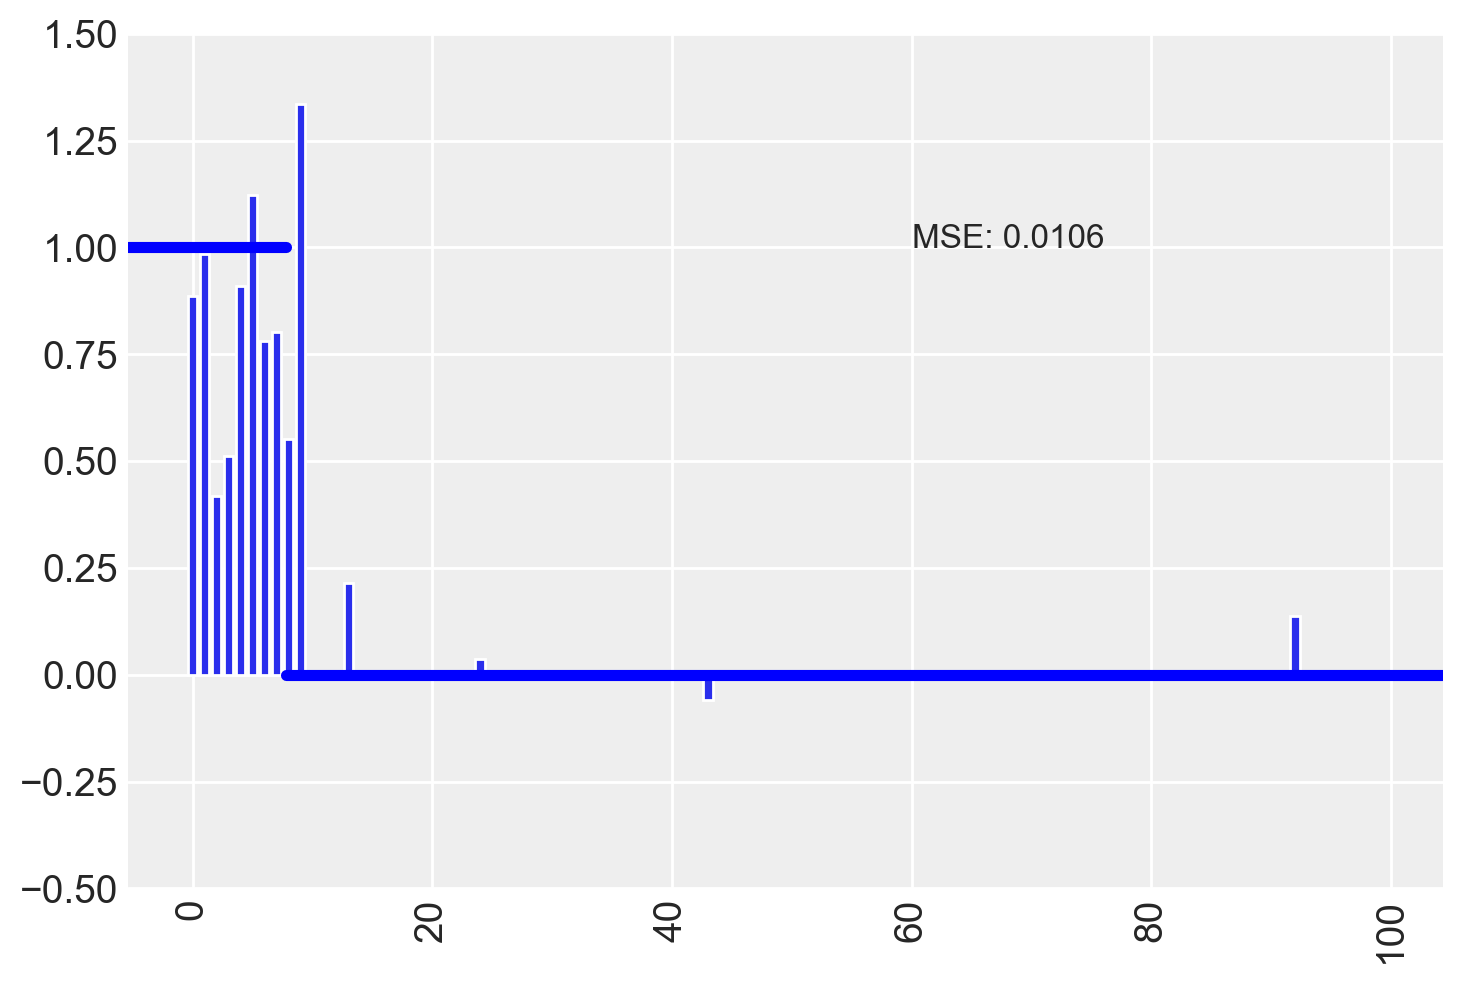

In [94]:
plot_estimates(condEst)

Anche in questo caso, osserviamo una netta distinzione tra i due insiemi di predittori.

Infine, calcoliamo lo stimatore finale come prodotto tra la stima condizionale e la probabilità di inclusione.

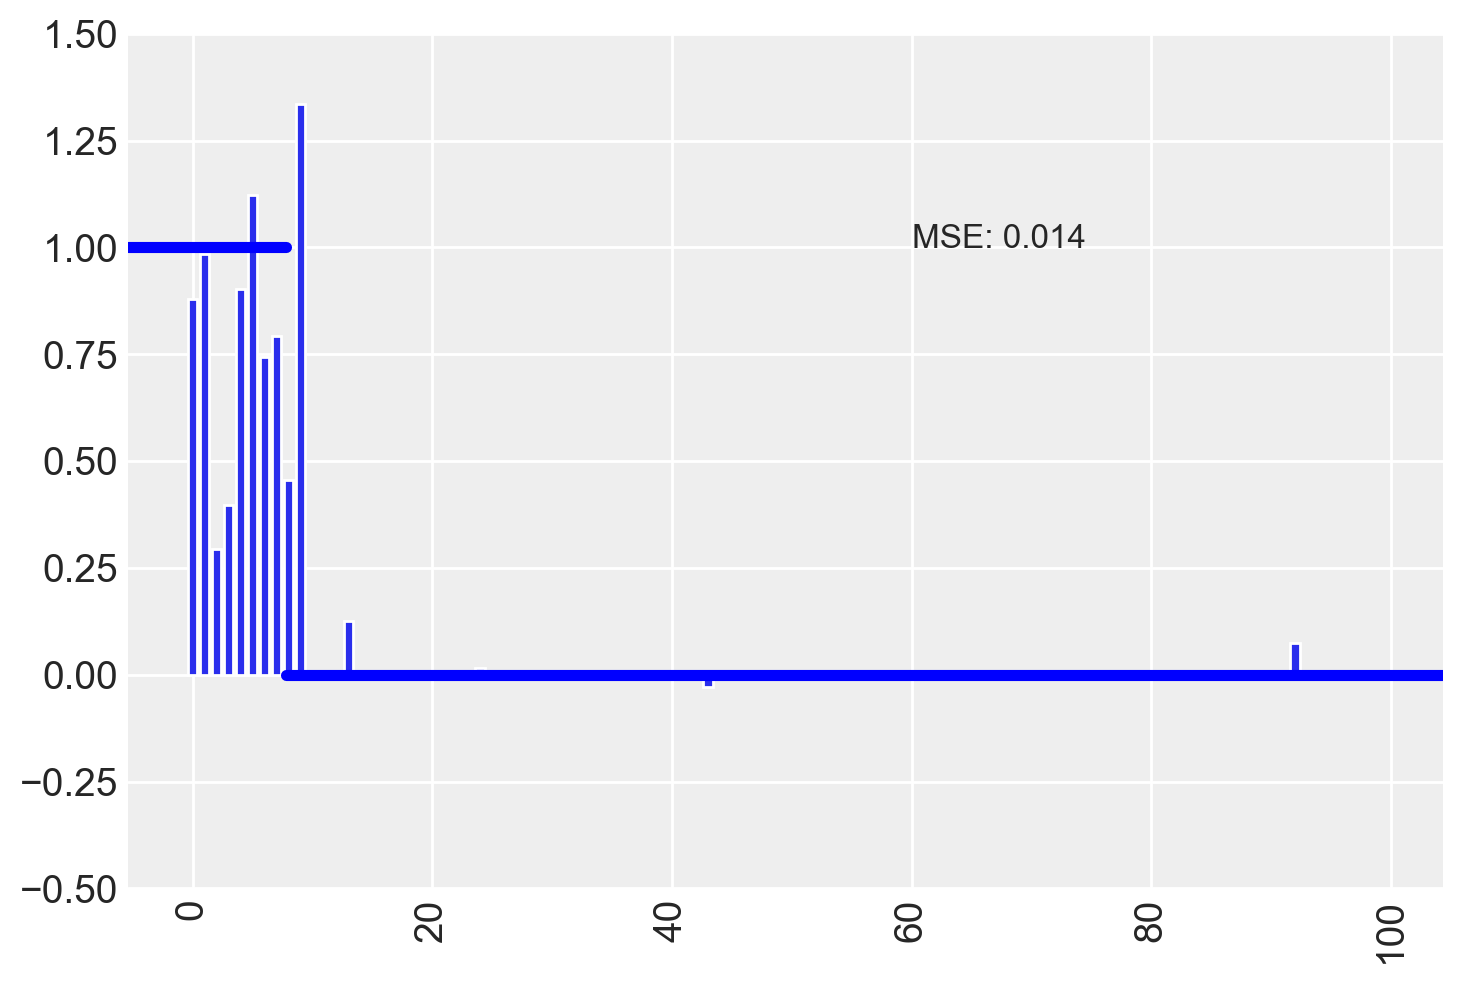

In [95]:
final_estimator = condEst * incl_prob

# Plot the final estimates
plot_estimates(final_estimator)

I risultati ottenuti suggeriscono che il metodo Spike and Slab si rivela efficace nell'ambito della selezione delle variabili per il problema in esame. In particolare, tale metodo conduce al valore minimo di MSE.

## Riflessioni Conclusive

L'uso di **priori informativi** e dell'approccio **Spike and Slab** offre un potente strumento per la **selezione di variabili** nei modelli statistici, specialmente in contesti con un gran numero di predittori e dati limitati. Questi metodi consentono di determinare in modo efficace quali predittori includere nel modello finale, riducendo al minimo il rischio di sovra-adattamento e mantenendo al contempo una buona capacità predittiva.

Il principale vantaggio dell'approccio Spike and Slab risiede nella sua capacità di combinare l'**informazione a priori** con l'evidenza dei dati, fornendo un metodo flessibile che permette di identificare le variabili rilevanti e di ridurre l'influenza di quelle irrilevanti. Questo processo di regolarizzazione facilita la costruzione di modelli più parsimoniosi e interpretabili, mantenendo un buon equilibrio tra complessità e accuratezza.

Oltre a questi vantaggi, i metodi basati su prior (come il Spike and Slab) possono essere utilizzati in parallelo con altri strumenti di selezione del modello, come i **criteri di informazione** (AIC, BIC, WAIC, LOO). Questi criteri, che valutano la qualità del modello sulla base della complessità e della capacità di adattamento ai dati, forniscono un approccio complementare alla selezione delle variabili. L'integrazione di queste diverse tecniche permette di ottenere un processo di selezione del modello più robusto e ben fondato.

In conclusione, l'approccio bayesiano alla selezione delle variabili, tramite l'uso di **priors informativi** e metodi di regolarizzazione come il **Spike and Slab**, rappresenta una strategia efficace e versatile per migliorare l'inferenza e la predittività dei modelli statistici. Questo approccio non solo permette di selezionare le variabili rilevanti in modo rigoroso, ma consente anche di incorporare le conoscenze pregresse e di ottenere modelli più parsimoniosi senza compromettere l'accuratezza.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p jax

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Oct 16 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

jax: 0.4.28

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
pandas    : 2.2.2
numpy     : 1.26.4
arviz     : 0.18.0
cmdstanpy : 1.2.4
seaborn   : 0.13.2
logging   : 0.5.1.2
scipy     : 1.14.0

Watermark: 2.4.3

